**1.Setup**

**1.1 Install Dependencies**

In [ ]:
!pip install tensorflow==2.12.0 opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow-gpu==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 32.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflo

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())


2.10.0
/device:GPU:0


In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

**1.2 Import Dependencies**

In [ ]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Import tensorflow dependencies 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

**1.3 Create Folder Structure**

In [ ]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories 
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

**2.Collecting Positives and Anchors**

*FOR POSITIVE AND ANCHOR IMAGES :* 

**Used the script : [colab_webcam](https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=ilLkpcKanPRb)**

*FOR NEGATIVE IMAGES :*

**2.1 Untar Labelled Faces in the Wild Dataset**

In [ ]:
 # http://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repo data/negative
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw',directory)):
    EX_PATH = os.path.join('lfw', directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

**3. Load and Preprocess Images**

**3.1 Get Image Directories**

In [ ]:
# tf.data.Dataset.list_files -> create a set or pipeline for each file within a specific directory
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

**3.2 Preprocessing - Scale and Resize**

In [ ]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

**3.3 Create Labelled Dataset**

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()

In [ ]:
samples.next()

(b'data/anchor/829f4320-f95f-11ed-9b2d-0242ac1c000c.jpg',
 b'data/positive/4490b1aa-f963-11ed-9b2d-0242ac1c000c.jpg',
 1.0)

**3.4 Build Train and Test Partition**

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

**4. Model Engineering**

**4.1 Build Embedding Layer**

In [ ]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

**4.2 Build Distance Layer**

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

**4.3 Make Siamese Model**

In [ ]:
def make_siamese_model(): 
    
    input_image = Input(name='input_img', shape=(100,100,3))
    
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_network = make_siamese_model()

In [ ]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

**5. Model Training**

**5.1 Setup Loss and Optimizer**

In [ ]:
# loss function 
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
# optimizer
opt = tf.keras.optimizers.Adam(1e-4)

**5.2 Establish Checkpoints**

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_network=siamese_network)

**5.3 Build Train Step Function**

In [ ]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_network(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_network.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_network.trainable_variables))
    
    return loss

**5.4 Build Training Loop**

In [ ]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)


**5.5 Train the Model**

In [ ]:
EPOCHS = 50


In [ ]:
train(train_data, EPOCHS)



 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 16s 208ms/step

 Epoch 2/50
27/27 [==============================] - 5s 189ms/step

 Epoch 3/50
27/27 [==============================] - 5s 192ms/step

 Epoch 4/50
27/27 [==============================] - 5s 193ms/step

 Epoch 5/50
27/27 [==============================] - 5s 192ms/step

 Epoch 6/50
27/27 [==============================] - 5s 192ms/step

 Epoch 7/50
27/27 [==============================] - 5s 193ms/step

 Epoch 8/50
27/27 [==============================] - 5s 191ms/step

 Epoch 9/50
27/27 [==============================] - 5s 193ms/step

 Epoch 10/50
27/27 [==============================] - 5s 194ms/step

 Epoch 11/50
27/27 [==============================] - 5s 195ms/step

 Epoch 12/50
27/27 [==============================] - 5s 195ms/step

 Epoch 13/50
27/27 [=====

**6. Evaluate Model**

**6.1 Import Metrics**

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

**6.2 Make Predictions**

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next() #batch of test data

In [ ]:
y_hat = siamese_network.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 279ms/step


array([[5.9581409e-17],
       [9.9999511e-01],
       [9.9997294e-01],
       [1.0000000e+00],
       [5.0582855e-10],
       [9.9999940e-01],
       [8.9926615e-08],
       [5.3065360e-12],
       [4.0084876e-12],
       [5.6336984e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [8.6554581e-07],
       [9.9997032e-01],
       [8.7375203e-13],
       [1.9085342e-15]], dtype=float32)

In [ ]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]

In [ ]:
y_true


array([0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.],
      dtype=float32)

**6.3 Calculate Metrics**

In [ ]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [ ]:
n = Precision()
n.update_state(y_true, y_hat)
n.result().numpy()

1.0

**6.4 Visualize Results**

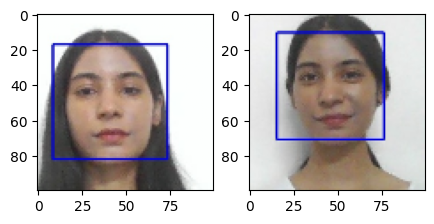

In [ ]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(test_input[10])
plt.subplot(1,2,2)
plt.imshow(test_val[10])
plt.show()

**7. Save Model**

In [ ]:
siamese_network.save('siamesemodel.h5')

In [ ]:
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
model.predict([test_input, test_val])

1/1 [==============================] - 1s 787ms/step


array([[5.9581409e-17],
       [9.9999511e-01],
       [9.9997294e-01],
       [1.0000000e+00],
       [5.0582855e-10],
       [9.9999940e-01],
       [8.9926615e-08],
       [5.3065360e-12],
       [4.0084876e-12],
       [5.6336984e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [8.6554581e-07],
       [9.9997032e-01],
       [8.7375203e-13],
       [1.9085342e-15]], dtype=float32)

In [ ]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

**8. Real Time Test**

**8.1 Verification Function**

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return verified

**8.2 Real Time Verification**

**Used the script : [colab_webcam](https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=ilLkpcKanPRb)**

*Setup application_data folder.  
once directories are created : Add any 50 images from the positive images to the verification_images folder.*

In [ ]:
input_img = os.path.join('application_data', 'input_image')
verifi_img = os.path.join('application_data', 'verification_images')
os.makedirs(input_img)
os.makedirs(verifi_img)

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from matplotlib import pyplot as plt
!pip install keyboard


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
import os
import uuid
import keyboard
import cv2
import matplotlib.pyplot as plt

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for the specified key to be pressed.
            await new Promise((resolve) => {
                document.addEventListener('keydown', (event) => {
                    if (event.key === 'c') {  // Change the key as per your requirement
                        resolve();
                    }
                });
            });

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            video.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')

    display(js)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))

    # Get OpenCV format image
    img = js_to_image(data)

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)

    # Draw face bounding box on the image
    for (x, y, w, h) in faces:
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Generate a unique filename for the image
    filename = os.path.join('application_data/input_image', '{}.jpg'.format('input_image'))
    img = img[120:120+250, 220:220+250, :]
    # Save the image
    cv2.imwrite(filename, img)
    return filename

<IPython.core.display.Javascript object>

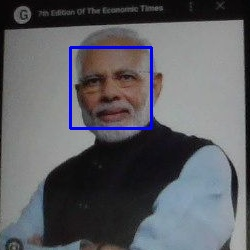

1/1 [==============================] - 0s 22ms/step
False


In [ ]:
try:
  filename = take_photo('input_image.jpg')
  display(Image(filename))
  verified = verify(model, 0.9, 0.7)
  print(verified)
except Exception as err:
  print(str(err))